In [12]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
import seaborn as sns
import wfdb
from wfdb import processing
import random
from scipy import signal

In [3]:
#Loading Training Data
train_data = pd.read_csv('mitbih_train.csv')

In [4]:
#Preview Training Data
row_no, col_no = train_data.shape
print(f'There are {row_no} rows and {col_no} columns')

There are 87553 rows and 188 columns


In [5]:
#Targets
y_df = train_data.iloc[:, -1]
y_df.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0.000000000000000000e+00.88, dtype: float64

In [6]:
#Convert to Int
y_df = y_df.astype('int')
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 0.000000000000000000e+00.88, dtype: int32

In [7]:
#Features
X_df = train_data.iloc[:, :-1]
X_df.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.78,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Check each class counts
unique, count = np.unique(y_df, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {count}')

unique values: [0 1 2 3 4]
counts: [72470  2223  5788   641  6431]


<BarContainer object of 5 artists>

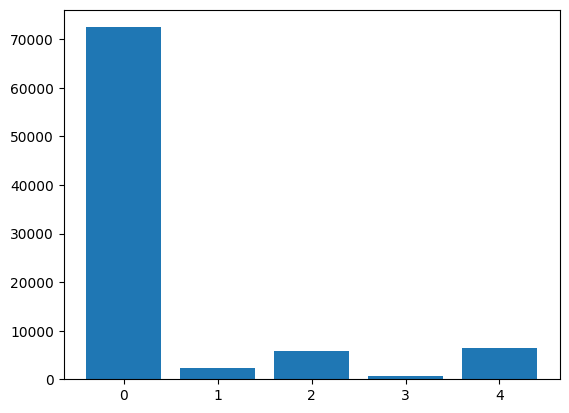

In [9]:
plt.bar(unique,count)

In [10]:
#Assign class names using dictionary
#Data Source: Physionet's MIT-BIH Arrhythmia Dataset
#Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

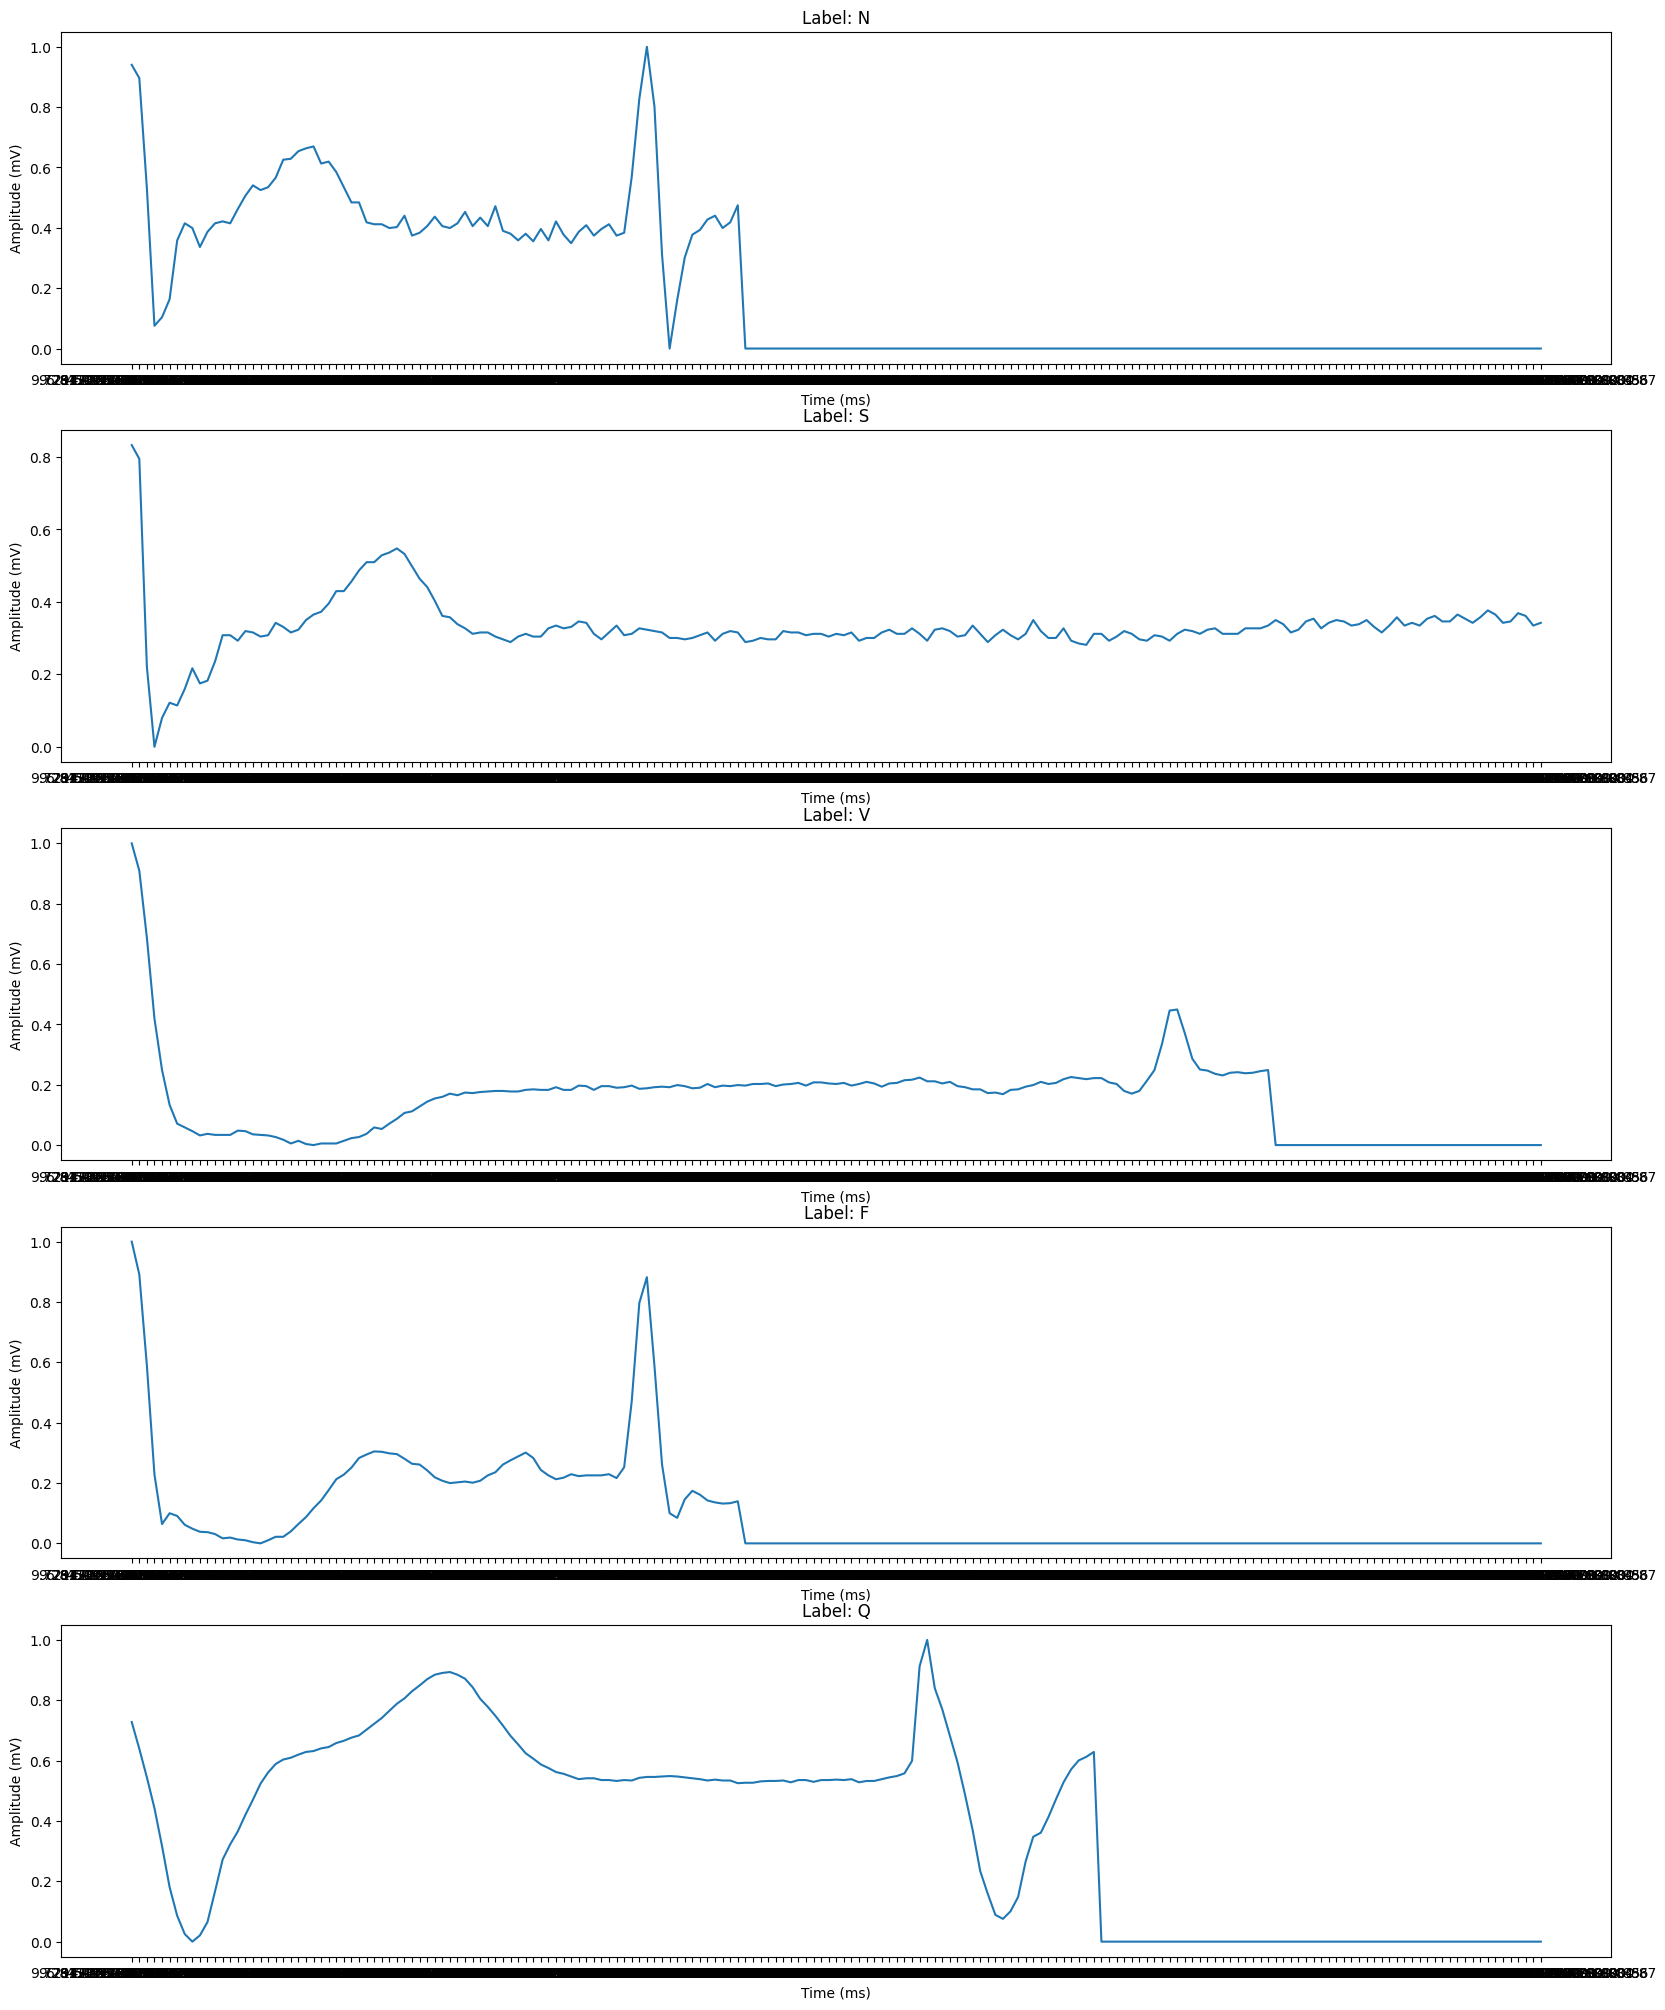

In [11]:
#Preview Class N ECG Shape
fig, ax = plt.subplots(5, 1, figsize=(20, 25))

for i in range(5):
    ax[i].plot(X_df.loc[y_df[y_df == i].sample().index[0]])
    ax[i].set_title(f'Label: {class_names[i]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

It can be seen that the training data has class inbalance issues. Among all the cases affected by arrhythmia (Class 1 - 4), Class 3 contains significantly less data with a count of 641 compared with the other three, followed by Class 1, with a count of 2223. Therefore, we will do some data augmentation in the following to balance the classes.

In [13]:
def augment_signal(signal):
    # Randomly select an augmentation technique
    choice = random.choice(['stretch', 'squeeze', 'add_noise'])
    
    # Stretching
    if choice == 'stretch':
        scale = np.random.uniform(0.9, 1.1)
        new_len = int(len(signal) * scale)
        signal = signal[:new_len]
        signal = signal + np.random.normal(0, 0.05, new_len)
        signal = signal[:len(signal)-1] if len(signal) % 2 != 0 else signal
        
    # Squeezing
    elif choice == 'squeeze':
        scale = np.random.uniform(0.7, 0.9)
        new_len = int(len(signal) * scale)
        signal = signal[:new_len]
        signal = signal + np.random.normal(0, 0.05, new_len)
        signal = signal[:len(signal)-1] if len(signal) % 2 != 0 else signal
        
    # Adding noise
    elif choice == 'add_noise':
        signal = signal + np.random.normal(0, 0.05, len(signal))
        
    return signal

In [14]:
def augment_data(data, num_augmentations):
    augmented_data = []
    
    for i in range(num_augmentations):
        for j in range(len(data)):
            signal = data.iloc[j, :-1].values
            augmented_signal = augment_signal(signal)
            augmented_data.append(np.concatenate((augmented_signal, [3])))
    
    return pd.DataFrame(augmented_data)